# First Real Toy NN 

### Needed Imports

In [18]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cifar

### Data Generation 

Data will be a spiral dataset which is generated from the following code:

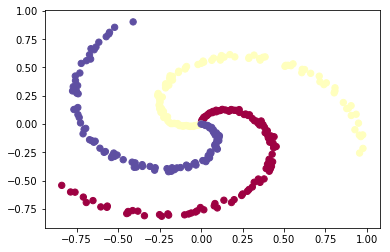

In [19]:
N = 100  # number of  points per class
D = 2  # dimensionality
K = 3  # number of classes
X = np.zeros((N*K, D))  # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8')  # class labels
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)  # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.rand(N) * 0.2  # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

# Lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

Normally the data should be preprocessed such that each feature should have 0 mean and unit std deviation, but this step is useless sinche the features are already in the range -1 to 1.

## Training a Softmax Linear Classifier 

### Parameter Initialization 

The Softmax classifier has a linear score function and uses the cross-entropy loss. The parameters of the linear classifier consist of a weight matrix W and a bias vector b for each class. These parameters are initialize to random numbers:

In [20]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3  # regularization strength

Notice the other 2 hyperparameters, they will be explained later

### Compute class scores 

The class score is very easy to compute, it is just a linear mapping:

In [21]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

In this example we have 300 2-D points and the scores array will have size [300x3] (3 classes)

### Compute the loss 

First the data loss needs to be computed, it is defined as the average cross-entropy loss.

In [22]:
def compute_data_loss(X, scores):
    num_examples = X.shape[0]
    # get unnormalized probabilities
    exp_scores = np.exp(scores)
    # normalize them for each example
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # get the log probabilities
    correct_logprobs = -np.log(probs[range(num_examples), y])
    # compute and return the average cross-entropy loss
    return np.sum(correct_logprobs)/num_examples, probs

Compute also the regularization loss

In [23]:
def compute_reg_loss(W, reg):
    return 0.5*reg*np.sum(W*W)

Combine both partial loss into the total loss function

In [24]:
def compute_loss(X, W, scores, reg):
    data_loss, probs = compute_data_loss(X, scores)
    reg_loss = compute_reg_loss(W, reg)
    return data_loss + reg_loss, probs

### Compute Analytic Gradient with Backpropagation 

In [25]:
def backpropagate(probs, X, W, y, reg):
    num_examples = probs.shape[0]
    
    # compute the external derivative
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    # and now the internal ones
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W  # the regularization gradient
    
    return dW, db

This will give the gradients to update the parameters

In [26]:
def update_parameters(W, b, dW, db, step_size):
    W += -step_size * dW
    b += -step_size * db

### Putting all together 

#### Training the linear classifier

Using the functions above 

In [27]:
# Train the Linear Classifier
def train(X, y, W, b, step_size, reg):
    num_examples = X.shape[0]
    
    new_b = b.copy()
    new_W = W.copy()
    
    # init the gradient descent loop
    for i in range(200):
        
        # evaluate class scores, [N x K]
        scores = np.dot(X, new_W) + new_b
        
        # compute loss and probs
        loss, probs = compute_loss(X, new_W, scores, reg)
        
        # print some iterations
        if i % 10 == 0:
            print("iteration %d: loss %f" % (i, loss))
            
        dW, db = backpropagate(probs, X, new_W, y, reg)
        update_parameters(new_W, new_b, dW, db, step_size)
    
    return new_W, new_b

In [28]:
W, b = train(X, y, W, b, step_size, reg)

iteration 0: loss 1.101350
iteration 10: loss 0.897135
iteration 20: loss 0.820342
iteration 30: loss 0.784678
iteration 40: loss 0.765613
iteration 50: loss 0.754443
iteration 60: loss 0.747473
iteration 70: loss 0.742924
iteration 80: loss 0.739854
iteration 90: loss 0.737728
iteration 100: loss 0.736226
iteration 110: loss 0.735148
iteration 120: loss 0.734363
iteration 130: loss 0.733786
iteration 140: loss 0.733358
iteration 150: loss 0.733037
iteration 160: loss 0.732797
iteration 170: loss 0.732615
iteration 180: loss 0.732476
iteration 190: loss 0.732371


Using all code inline

In [29]:
# To be implemented

#### Evaluate the classifier 

In [30]:
def predict(X, W, b, y):
    scores = np.dot(X, W) + b
    predicted_class = np.argmax(scores, axis=1)
    return np.mean(predicted_class == y)

In [31]:
accuracy = predict(X, W, b, y)
print("training accuracy: %.2f" % accuracy)

training accuracy: 0.53


## Training a Neural Network 

We will need an additional hidden layer

In [48]:
# initialize parameters randomly
h = 100  # size of hidden layer
W = 0.01 * np.random.randn(D, h)
b = np.zeros((1, h))
W2 = 0.01 * np.random.randn(h, K)
b2 = np.zeros((1, K))

Also the score computation changes

In [49]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b)  # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

Starting the backpropagation

In [45]:
num_examples = X.shape[0]
# first compute loss
# compute the class probabilities
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

# compute the loss: average cross-entropy loss and regularization
corect_logprobs = -np.log(probs[range(num_examples),y])
data_loss = np.sum(corect_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
loss = data_loss + reg_loss

The idea is to start from the end and to propagate to the beginning
First we need to compute dL/df [dscores]

In [44]:
# compute the external derivative
dscores = probs
dscores[range(num_examples), y] -= 1
dscores /= num_examples

Then we should compute the dL/dW2 = dL/df * df/dW2

And the same for db2

In [40]:
# start from the end, first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

Now we need to compute dhidden = dL/dh = dL/df * df/dh. Please note that h is a ReLU, this is why the second statement is needed. f = hW2 + b2 => df/dh = W2

In [46]:
# then move to the first layer, but first compute the dhidden
dhidden = np.dot(dscores, W2.T)
dhidden[hidden_layer <= 0] = 0

And now we are ready to compute the gradient of the parameters of the first layer

In [47]:
# finally into W, b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

With this we have finished explaining the various steps, time to combine everything

#### Full training code 

In [50]:
# initialize parameters and hyperparameters
step_size = 1e-0
reg = 1e-3  # regularization strength

h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b)  # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2  
    
    # compute class probabilities --> Softmax loss function
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # [N x K]
    
    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print("iteration %d: loss %f" % (i, loss))
        
    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    # backprop the gradient to all parameters starting from the output
    # first we need to backprop into W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
    
    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W
    
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2
    

iteration 0: loss 1.098568
iteration 1000: loss 0.262510
iteration 2000: loss 0.241172
iteration 3000: loss 0.231602
iteration 4000: loss 0.228247
iteration 5000: loss 0.227210
iteration 6000: loss 0.226736
iteration 7000: loss 0.226558
iteration 8000: loss 0.226447
iteration 9000: loss 0.226385


And the trained accuracy is:

In [51]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print("training accuracy: %.2f" % (np.mean(predicted_class == y)))

training accuracy: 0.99
